# Housing Agent Model based on Geographic distances

In [2]:

# Import necessary libraries
import numpy as np
import geopandas as gpd
import osmnx as ox
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import housing_model_functions as hm  # Python file with all functions
import warnings
from itertools import permutations
from matplotlib.cm import get_cmap

warnings.filterwarnings('ignore')

## Define City and District data

### Data Imports (OSMNX)

In [ ]:
warnings.filterwarnings('ignore')

# Define New York City as city to be analyzed
place_name = "New York City"

# OSMNX Public data downloads:

# Download district borders. Here make sure admin level matches district level by observing borders df
borders = ox.features_from_place(place_name, tags={"boundary": "administrative", "admin_level": "8"})

# Probably there will be repeated districts in the df so just select the desired ones with a similar method as below. Perhaps changing 'ref' column name and the end of range to num of districts + 1.
districts_within_city = borders[borders['name'].isin(['The Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'])]

# Gets city boundary
city_boundary = ox.geocode_to_gdf(place_name, which_result = 1) 

# Gets districts within city boundary
districts_within_city = gpd.sjoin(districts_within_city, city_boundary, how = "inner", predicate = 'within')
districts_within_city = districts_within_city[['name_left', 'geometry']].rename(columns={'name_left': 'District'})

# Download the road network data and Convert to GeoDataFrame for easier manipulation
road_df = ox.graph_from_place(place_name, network_type = "drive")
road_df = ox.graph_to_gdfs(road_df, nodes = False)

# Download parks (Only include named parks with polygon and multipolygon shapes to reduce amenity saturation)
parks = ox.features_from_place(place_name, tags = {"leisure" : "park"})
parks = parks[parks.geometry.type.isin(['Polygon', 'MultiPolygon'])]
parks = parks[~parks['name'].isna()]
parks = parks[['geometry']]
parks['Type'] = 'park'

# Download schools
schools = ox.features_from_place(place_name, tags = {'amenity' : 'school'})
schools = schools[['geometry']]
schools['Type'] = 'school'

# Download supermarkets
supermarkets = ox.features_from_place(place_name, tags = {'shop' : 'supermarket'})
supermarkets = supermarkets[['geometry']]
supermarkets['Type'] = 'supermarket'

# Download landmarks
landmarks = ox.features_from_place(place_name, tags = {'tourism' : ['attraction', 'gallery', 'artwork', 'viewpoint']})
landmarks = landmarks[['geometry']]
landmarks['Type'] = 'landmark'

# Create joint amenity DataFrame
amenities_df = pd.concat([parks, schools, supermarkets, landmarks], axis=0)
amenities_df = gpd.sjoin(amenities_df, districts_within_city, how = "left", predicate = 'within')
amenities_df = amenities_df.rename(columns={'name_left': 'District'})
amenities_df = amenities_df.dropna(subset=['geometry', 'Type', 'District'])
amenities_df = amenities_df[['geometry', 'Type', 'District']]

# Download residential areas
residential_areas = ox.features_from_place(
    place_name, tags = {'building': ['apartments', 'bungalow', 'cabin', 'detached', 'annexe', 'farm', 'house', 'houseboat', 'residential', 'semidetached_house', 'terrace']})
residential_areas = gpd.GeoDataFrame(residential_areas['geometry'])
residential_areas = gpd.sjoin(residential_areas, districts_within_city, how = "inner", predicate = 'within')
residential_areas = residential_areas[['geometry', 'District']]

# Following Lines are necessary for accurate centroid calculation for agent placing.

# Convert Residential from coordinate to metric system. Note: epsg defines the coordinate system we want to use.
projected_residence = residential_areas.to_crs(epsg=2263)

# Extract centroids from the geometry column for comparison
projected_residence['centroid'] = projected_residence['geometry'].centroid
projected_residence = projected_residence[['centroid', 'District']]

# Convert centroids back to geographic coordinates 
projected_residence = projected_residence['centroid'].to_crs(epsg=4326)
projected_residence = gpd.GeoDataFrame(projected_residence)

# Extract latitude and longitude from centroids
projected_residence[['latitude', 'longitude']] = projected_residence['centroid'].apply(
                lambda point: pd.Series([point.y, point.x])
            )
projected_residence['District'] = residential_areas['District']

# Reduce the data to only necessary columns and reset index 
residences_reduced = projected_residence[['latitude', 'longitude', 'District']]
residences_reduced = residences_reduced.reset_index(drop=True)

### Data Imports (From Researched Data Excel)

In [ ]:
# Researched Price Data Import:

# Import NYC data from auxiliary excel file.
file_name = "NYC_data.xlsx"

# Import Borough Price Data
yearly_prices = pd.read_excel(file_name, sheet_name= 'Price Data' ,index_col = 0)

# Import Population Data
population = pd.read_excel(file_name, sheet_name= 'Population Data' ,index_col = 0)

# Import Income Data
income = pd.read_excel(file_name, sheet_name= 'Income Data')

# Import Housing Growth Data
growth_rate = pd.read_excel(file_name, sheet_name= 'Housing Growth (2017-2021)' ,index_col = 0)

# Adapt population and income dataframes to work with model
population, income = hm.model_conversions(population,income)

# Determining optimal parameters

## Testing Convergence, Choice of Num_iterations

In [ ]:
# Set seed for reproducibility
np.random.seed(12)

# Gather district names
districts = list(yearly_prices.columns) 

# Set arbitrary year for testing
year = 2019 # To predict 2020 prices
median_price = np.median(yearly_prices.loc[year]) 

# Affluence group parameters 
affluence_vals = np.array(income.iloc[:,0])

# Initial affluence proportions   
affluence_dist = np.array(income.iloc[:,1])
 
# Specify the number of agents and amenities to be placed
num_agents = 1000 
num_amenities = 200

# Set inflationary weights for agents and amenities
weight = 0.8

amenity_multiplier = {
    'park': .2* median_price,
    'school': .4 * median_price,
    'supermarket': .1 * median_price,
    'landmark': .3 * median_price
}
  
# Initialize results array and set largest iteration limit
iteration_limit = 100
iteration_tests_same = np.zeros((iteration_limit, len(districts)))   

# Call initialize function
model_agents, model_amenities, radius, radius_amenity = hm.grid_initializer(num_agents, num_amenities, population, affluence_vals, affluence_dist, residences_reduced, amenities_df)

# Initialize prices
initial_prices = hm.initial_price_dist(model_agents, year, yearly_prices)
for k, district in enumerate(districts):
    
    # Select residences within each district
    initial_prices_k = initial_prices[initial_prices['District'] == district]
    iteration_tests_same[0, k] = np.average(initial_prices_k['price'])
    
 # Do the first house values calculation
vals = hm.update_house_prices(initial_prices, weight, radius , model_amenities, amenity_multiplier, radius_amenity)

for k, district in enumerate(districts):
    
    # Select residences within each district
    vals_k = vals[vals['District'] == district]
    iteration_tests_same[1, k] = np.average(vals_k['price'])

# Do remaining evaluations             
for i in range(2, iteration_limit):
    vals,_, swap_tot = hm.new_iteration(vals, weight, radius , model_amenities, amenity_multiplier, radius_amenity)   
    for k, district in enumerate(districts):
        
        # Select residences within each district
        vals_k = vals[vals['District'] == district]
        iteration_tests_same[i, k] = np.average(vals_k['price'])


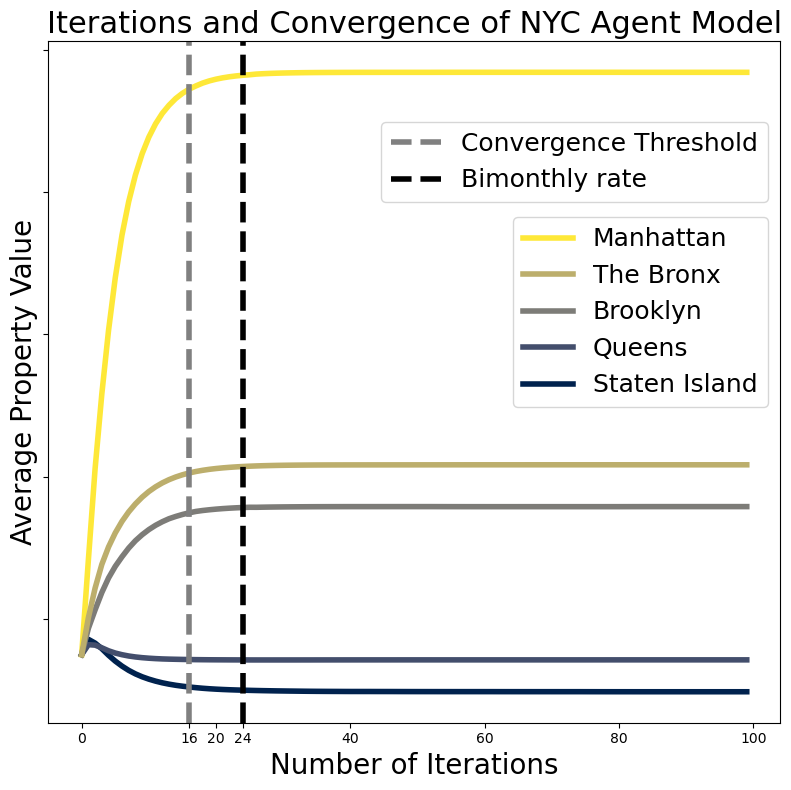

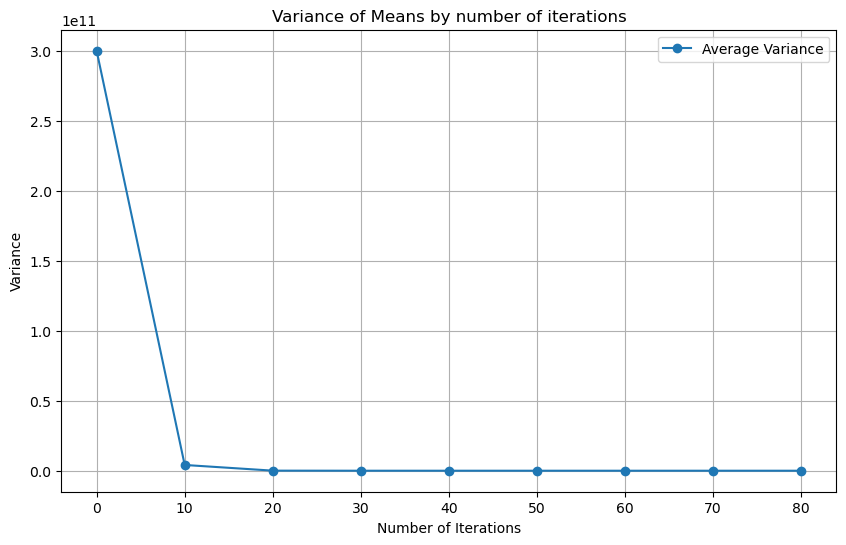

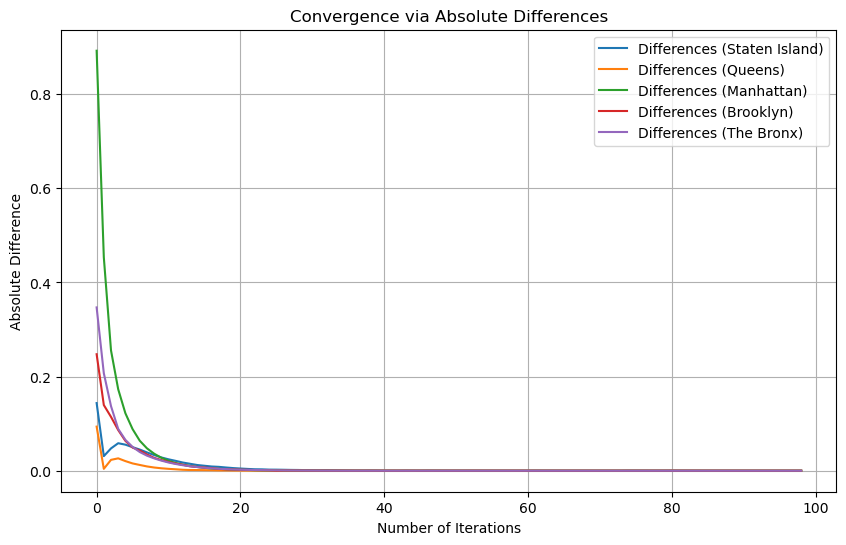

In [ ]:
# Determine the x values
x_values = np.arange(iteration_tests_same.shape[0])

# Use the cividis colormap to match rest of report
cividis = get_cmap('cividis')
num_lines = iteration_tests_same.shape[1]

# Generate evenly spaced colors
colors = [cividis(i / (num_lines - 1)) for i in range(num_lines)]

colorsmapped = {'Manhattan': colors[4], 
                'Brooklyn': colors[2],
                'The Bronx': colors[3],
                'Queens': colors[1],
                'Staten Island': colors[0]}
lines = []
plt.figure(figsize=(8, 8))
for col in range(num_lines):
    line, = plt.plot(
        x_values,
        iteration_tests_same[:, col],
        label=f'{yearly_prices.columns[col]}',
        color=colorsmapped[yearly_prices.columns[col]],
        linewidth=4 
    )
    lines.append(line)

# Add vertical lines
vline1 = plt.axvline(x=16, color='gray', linestyle='--', linewidth=4)
vline2 = plt.axvline(x=24, color='black', linestyle='--', linewidth=4, label="Bi-monthly rate")

# Add axis ticks at 16 and 24
plt.xticks(list(plt.xticks()[0])[1:-1] + [16, 24])

# Customize fonts
font_size = 20 
plt.xlabel('Number of Iterations', fontsize=font_size)
plt.ylabel('Average Property Value', fontsize=font_size)
plt.title('Iterations and Convergence of NYC Agent Model', fontsize=font_size + 2)


# Set a specific legend order
desired_order = ['Manhattan', 'The Bronx', 'Brooklyn', 'Queens', 'Staten Island']
handles_labels = dict(zip([line.get_label() for line in lines], lines))  # Map labels to lines
sorted_handles = [handles_labels[label] for label in desired_order if label in handles_labels]

# Add the legend
legend_1 = plt.legend(sorted_handles, desired_order, fontsize=font_size - 2, loc='upper right', frameon=True,bbox_to_anchor=(1, .76), ncol=1)
legend_2 = plt.legend([vline1, vline2], ['Convergence Threshold', 'Bimonthly rate'], fontsize=font_size - 2, loc='upper right', bbox_to_anchor=(1, .9),frameon=True)
plt.gca().add_artist(legend_1)
plt.tick_params(axis='y', labelleft=False, labelbottom=True)
plt.tight_layout()
plt.savefig('output_plot.png', pad_inches=4, dpi = 300)
plt.show()

# Variance over intervals
interval = 10
variances = [np.var(iteration_tests_same[i:i+interval, :], axis=0) for i in range(0, len(iteration_tests_same) - interval, interval)]

# Plot variance over intervals
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(variances)) * interval, np.mean(variances, axis=1), '-o', label='Average Variance')
plt.xlabel('Number of Iterations')
plt.ylabel('Variance')
plt.title('Variance of Means by number of iterations')
plt.legend()
plt.grid(True)
plt.show()

# Plot absolute differences
abs_differences = np.abs(np.diff(iteration_tests_same, axis=0)) / iteration_tests_same[:-1]
plt.figure(figsize=(10, 6))
for col in range(iteration_tests_same.shape[1]):
    plt.plot(x_values[:-1], abs_differences[:, col], label=f'Differences ({yearly_prices.columns[col]})')
plt.xlabel('Number of Iterations')
plt.ylabel('Absolute Difference')
plt.title('Convergence via Absolute Differences')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Calculate maximum absolute differences as percentage
abs_max_percent = np.max(abs_differences, axis=1) * 100

# Set arbitrary threshold, which we set to 1%
threshold = 1

for i in range(len(abs_max_percent)):
    if abs_max_percent[i] >= threshold:
        continue
    else:
        print(f'After {i} iterations, threshold satisfied with Mean Absolute Difference: {np.round(abs_max_percent[i],4)}%.')
        break

After 16 iterations, threshold satisfied with Mean Absolute Difference: 0.8981%.


## Testing if Initial Affluence (Agent) Distribution matters

Testing for different initial grids given same number of agents, amenities and also same affluence values and distributions from data. Note amenity and agent locations are the same, only changing initial affluence.

In [8]:
# Set seed for reproducibility
np.random.seed(12)

# Set arbitrary year for testing
year = 2019
median_price = np.median(yearly_prices.loc[year])

# Set iteration limit based on previous result, 24 equivalent to twice a month evaluations
n_iterations = 24
    
# Affluence group parameters 
affluence_vals = np.array(income.iloc[:,0])

# Initial affluence proportions   
affluence_dist = np.array(income.iloc[:,1])
 
# Specify the number of agents and amenities to be placed
num_agents = 1000 
num_amenities = 200

# Set inflationary weights for agents and amenities
weight = 0.8

districts = list(yearly_prices.columns) 

amenity_multiplier = {
    'park': .2* median_price,
    'school': .4 * median_price,
    'supermarket': .1 * median_price,
    'landmark': .3 * median_price
}
  

# Call initialize function
affluences, model_amenities, radius, amenity_radius = hm.grid_initializer(num_agents, num_amenities, population, affluence_vals, affluence_dist, residences_reduced, amenities_df, 100)
results_array = np.zeros((len(affluences), 5))
for i in range(len(affluences)):
    
    initial_prices = hm.initial_price_dist(affluences[i], year, yearly_prices)
    # Do the first house values calculation
    vals = hm.update_house_prices(initial_prices, weight, radius, model_amenities, amenity_multiplier, amenity_radius)

    # Calculate number of agents to add at each iteration
    for j in range(n_iterations):
        vals,_, swap_tot = hm.new_iteration(vals, weight, radius, model_amenities, amenity_multiplier, amenity_radius)
        
    for k, district in enumerate(districts):
        # Select residences within each district
        vals_k = vals[vals['District'] == district]
        results_array[i, k] = np.round(np.average(vals_k['price']))



In [41]:
# Calculate column-wise statistics for last iteration
means = np.mean(results_array, axis=0)
std_devs = np.std(results_array, axis=0)
coeff_variation = std_devs / means

print(f"Coefficient of Variation maximum: {np.round(np.max(coeff_variation),5)* 100}%.")

Coefficient of Variation maximum: 1.804%.


# Amenity weight tests

Note: MAPE values correspond to next year price approximations. Ex. 2014 MAPE value is in comparison to 2015 data.

### Testing Data Based Amenity Weights

In [11]:
# Set seed for reproducibility
np.random.seed(12)

# Set iteration limit based on previous result, 24 equivalent to twice a month evaluations
n_iterations = 24
    
# Affluence group parameters 
affluence_vals = np.array(income.iloc[:,0])

# Initial affluence proportions   
affluence_dist = np.array(income.iloc[:,1])
 
# Specify the number of agents and amenities to be placed
num_agents = 1000 
num_amenities = 200

# Set inflationary weights for agents and amenities
weight = 0.8

districts = list(yearly_prices.columns) 

# Call initialize function
model_agents, model_amenities, radius, radius_amenity = hm.grid_initializer(num_agents, num_amenities, population, affluence_vals, affluence_dist, residences_reduced, amenities_df)

data_results_df = pd.DataFrame(columns=['MAPE'], index=yearly_prices.index[:-1])

for i in range(yearly_prices.shape[0] - 1):
    current_year = yearly_prices.index[i]
    median_price = np.median(yearly_prices.loc[current_year])
    next_year = yearly_prices.index[i + 1]
    amenity_multiplier = {
    'park': .1* median_price,
    'school': .4 * median_price,
    'supermarket': .2 * median_price,
    'landmark': .1 * median_price
}
    
    initial_prices = hm.initial_price_dist(model_agents, current_year, yearly_prices)
    
    # Do the first house values calculation
    vals = hm.update_house_prices(initial_prices, weight, radius, model_amenities, amenity_multiplier, amenity_radius)

    # Calculate number of agents to add at each iteration
    for j in range(n_iterations):
        vals,_, swap_tot = hm.new_iteration(vals, weight, radius, model_amenities, amenity_multiplier, amenity_radius)
    
    # Calculate final prices
    prices_end = np.zeros(len(districts))
    for n, district in enumerate(districts):
        vals_district = vals[vals['District'] == district]
        prices_end[n] = np.round(np.average(vals_district['price']))

    # Calculate MAPE
    ape = hm.calculate_ape(prices_end, np.array(yearly_prices.loc[next_year]))
    mape = np.mean(ape)
    data_results_df.loc[current_year, 'MAPE'] = mape
    
# Display the results DataFrame
print(data_results_df)

print(f"9 year MAPE average: {np.mean(data_results_df.loc[:,'MAPE'])}")

            MAPE
Year            
2014   44.896111
2015   56.172947
2016   54.964136
2017   42.427436
2018   39.928778
2019   18.877355
2020   53.853222
2021   43.004677
2022  107.748531
9 year MAPE average: 51.31924364920086


## A discrete algorithm of optimization for amenity weights.

Based on brute force and repeated observations we have noticed that $\lambda$ seems to be purely inflationary and hence hypothesise that for every sufficiently reasonable $\lambda \in [0.5,0.9]$ there exists a combination of amenity weights that will yield a global minimum for that year. Hence, due to computation constraints we limit our testing to a set $\lambda$ value of $0.8$. Then, based on the aforementioned observations we test different permutations of weights that have worked in the past for us. 

All permutations of the amenity weight combinations $[0.1, 0.2, 0.2, 0.4]$, $[0.1, 0.2, 0.3, 0.4]$, $[0.1, 0.2, 0.4, 0.4]$, and $[0.1, 0.1, 0.2, 0.4]$ corresponding to **park**, **school**, **supermarket**, and **landmark**, respectively, were tested under $\lambda = 0.8$. These tests evaluated all distinct weight configurations to identify the approximate "best" combinations yielding a global minimum for each target year. With more computational resources, these results could serve as starting points for advanced optimization methods like Genetic Algorithms, L-BFGS-B, or other numerical techniques to refine and identify more precise weight approximations for improved model performance. We have attempted to implement these models but due to size of cartesian space numerous tests have incorrectly converged at saddle points, so these are our best approximates at the moment.

In [ ]:
# FIXED PARAMETERS
# Set seed for reproducibility
np.random.seed(12)
# Set arbitrary year for testing
year = 2018

# Set iteration limit based on previous result, 24 equivalent to twice a month evaluations
n_iterations = 24
    
# Affluence group parameters 
affluence_vals = np.array(income.iloc[:,0])

# Initial affluence proportions   
affluence_dist = np.array(income.iloc[:,1])
 
# Specify the number of agents and amenities to be placed
num_agents = 1000 
num_amenities = 200

# Set inflationary weight for agents
weight = 0.8

# Convert districts to ordered list
districts = list(yearly_prices.columns) 

# Compute all desired permutations

def unique_combinations(elements):
    # Use set to automatically handle duplicates
    unique_perms = set(permutations(elements))
    return list(unique_perms)

# We get this range from previous manual testing which satisfies desirable inflation
elements_middle_repeat = [.1, .2, .2, .4]
combinations_middle_repeat = unique_combinations(elements_middle_repeat)

elements_no_repeat = [.1, .2, .3, .4]
combinations_no_repeat = unique_combinations(elements_no_repeat)

elements_edge_repeat_upper = [.1, .2, .4, .4]
combinations_edge_repeat_upper = unique_combinations(elements_edge_repeat_upper)

elements_edge_repeat_lower = [.1, .1, .2, .4]
combinations_edge_repeat_lower = unique_combinations(elements_edge_repeat_lower)

# Merge all unique combinations into a single list
all_combinations = (
    combinations_middle_repeat +
    combinations_no_repeat +
    combinations_edge_repeat_upper +
    combinations_edge_repeat_lower
)

# Convert to array
all_combinations_array = np.array(all_combinations)

# Initialize grid
model_agents, model_amenities, radius, radius_amenities = hm.grid_initializer(num_agents, num_amenities, population,np.array(income.iloc[:, 0]), np.array(income.iloc[:, 1]),residences_reduced, amenities_df)

# Initialize results dataframe
results_df = pd.DataFrame(columns=['best amenity weights', 'best MAPE'], index=yearly_prices.index[:-1])

for i in range(yearly_prices.shape[0]-1):
    current_year = yearly_prices.index[i]
    median_price = np.median(yearly_prices.loc[current_year])
    next_year = yearly_prices.index[i + 1]
    print(f"Optimizing for year {current_year}...")

    # Pre-set best values
    best_mape = float('inf')
    best_amenities = None
    
    initial_prices = hm.initial_price_dist(model_agents, current_year, yearly_prices)
    med_price = np.median(yearly_prices.loc[current_year])
    next_year_prices = np.array(yearly_prices.loc[next_year])
    for j in range(all_combinations_array.shape[0]):
        amenity_weights = {
        'park': all_combinations_array[j,0]* median_price,
        'school': all_combinations_array[j,1]*median_price,
        'supermarket': all_combinations_array[j,2]*median_price,
        'landmark': all_combinations_array[j,3] *median_price}
        
         # Perform simulation for n_iterations
        vals = initial_prices
        for k in range(n_iterations):
            vals, _, _ = hm.new_iteration(vals, weight, radius, model_amenities, amenity_weights, radius_amenities)
        
        # Calculate final prices
        prices_end = np.zeros(len(districts))
        for n, district in enumerate(districts):
            vals_district = vals[vals['District'] == district]
            prices_end[n] = np.round(np.average(vals_district['price']))

        # Calculate MAPE
        ape = hm.calculate_ape(prices_end, np.array(yearly_prices.loc[next_year]))
        mape = np.mean(ape)
        
        # Check if this combination yields a better MAPE
        if mape < best_mape:
            best_mape = mape
            best_amenities = all_combinations_array[j,:]
            print(f"{all_combinations_array[j,:]} improved MAPE, new best MAPE for year {current_year} = {best_mape}.")
    # Store the best parameters for the current year
    results_df.loc[current_year, 'best amenity weights'] = best_amenities
    results_df.loc[current_year, 'best MAPE'] = best_mape
# Display the results DataFrame
print(results_df)    
print(f"9 year MAPE average: {np.mean(results_df.loc[:,'best MAPE'])}")

Optimizing for year 2014...
[0.2 0.4 0.1 0.2] improved MAPE, new best MAPE for year 2014 = 60.22675927199216.
[0.4 0.2 0.1 0.2] improved MAPE, new best MAPE for year 2014 = 57.45065142290664.
[0.1 0.4 0.2 0.2] improved MAPE, new best MAPE for year 2014 = 55.26523116702556.
[0.2 0.1 0.4 0.2] improved MAPE, new best MAPE for year 2014 = 39.754033912365045.
[0.2 0.1 0.4 0.1] improved MAPE, new best MAPE for year 2014 = 34.65451767968419.
[0.1 0.1 0.4 0.2] improved MAPE, new best MAPE for year 2014 = 28.685466563280055.
Optimizing for year 2015...
[0.2 0.4 0.1 0.2] improved MAPE, new best MAPE for year 2015 = 72.1288010782213.
[0.4 0.2 0.1 0.2] improved MAPE, new best MAPE for year 2015 = 71.55434137824875.
[0.1 0.4 0.2 0.2] improved MAPE, new best MAPE for year 2015 = 66.56819327131987.
[0.2 0.1 0.4 0.2] improved MAPE, new best MAPE for year 2015 = 51.27077915077117.
[0.1 0.2 0.4 0.2] improved MAPE, new best MAPE for year 2015 = 50.20160761881185.
[0.2 0.1 0.4 0.1] improved MAPE, new best

In [38]:
# Save the DataFrame to an Excel file
results_df.to_excel("Optimization_Results.xlsx", index=True, sheet_name="Reduction Algorithm Results")

In [30]:
import optuna

# Define the objective function
def objective_function(params, weight, model_agents, model_amenities, radius, yearly_prices, i, districts, hm, n_iterations, radius_amenity):
    # Initialize prices
    current_year = yearly_prices.index[i]
    next_year = yearly_prices.index[i + 1]
    initial_prices = hm.initial_price_dist(model_agents, current_year, yearly_prices)
    med_price = np.median(yearly_prices.loc[current_year])
    amenity_weights = {
        'park': params[0] * med_price,
        'school': params[1] * med_price,
        'supermarket': params[2] * med_price,
        'landmark': params[3] * med_price,
    }

    # Simulate over n_iterations
    vals = initial_prices
    for j in range(n_iterations):
        vals, _, _ = hm.new_iteration(vals, weight, radius, model_amenities, amenity_weights, radius_amenity)

    # Calculate final prices
    prices_end = np.zeros(len(districts))
    for n, district in enumerate(districts):
        vals_district = vals[vals['District'] == district]
        prices_end[n] = np.round(np.average(vals_district['price']))

    # Calculate MAPE
    ape = hm.calculate_ape(prices_end, np.array(yearly_prices.loc[next_year]))
    mape = np.mean(ape)
    return mape  # Objective is to minimize this value

def objective(trial):
    # Suggest parameter values
    park_weight = trial.suggest_float('park_weight', 0.0, 1.0)
    school_weight = trial.suggest_float('school_weight', 0.0, 1.0)
    supermarket_weight = trial.suggest_float('supermarket_weight', 0.0, 1.0)
    landmark_weight = trial.suggest_float('landmark_weight', 0.0, 1.0)
    
    params = [park_weight, school_weight, supermarket_weight, landmark_weight]
    
    # Evaluate MAPE for the specified year `i`
    mape = objective_function(
        params,
        weight,
        model_agents,
        model_amenities,
        radius,
        yearly_prices,
        current_year,
        districts,
        hm,
        n_iterations,
        radius_amenity
    )
    
    return mape  # Minimize MAPE

# Run trials for each year separately
best_results = {}

for i in range(len(yearly_prices.index) - 1):  # Loop through all years except the last
    current_year = i  # Set the current year index for the trial
    print(f"Running Optuna study for year index: {current_year}")
    
    # Create and optimize the study
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    
    # Save the results for the current year
    best_results[yearly_prices.index[current_year]] = {
        "Best Parameters": study.best_params,
        "Best MAPE": study.best_value
    }
    print(f"Year {yearly_prices.index[current_year]} Best Parameters: {study.best_params}")
    print(f"Year {yearly_prices.index[current_year]} Best MAPE: {study.best_value}")

# Final results
print("Best results per year:", best_results)


[I 2024-12-01 14:46:35,359] A new study created in memory with name: no-name-720dccce-6e32-4276-b838-7e637374b09c


Running Optuna study for year index: 0


[I 2024-12-01 14:46:58,169] Trial 0 finished with value: 154.34508302957295 and parameters: {'park_weight': 0.8614601345865232, 'school_weight': 0.2310800638499907, 'supermarket_weight': 0.04024488729379361, 'landmark_weight': 0.785225572052122}. Best is trial 0 with value: 154.34508302957295.
[I 2024-12-01 14:47:21,066] Trial 1 finished with value: 137.0221924307989 and parameters: {'park_weight': 0.5581550537437702, 'school_weight': 0.5169758462232047, 'supermarket_weight': 0.628751853343275, 'landmark_weight': 0.33055498278080164}. Best is trial 1 with value: 137.0221924307989.
[I 2024-12-01 14:47:44,117] Trial 2 finished with value: 112.83104657997205 and parameters: {'park_weight': 0.25258413843190497, 'school_weight': 0.26697155777948445, 'supermarket_weight': 0.2693234569795687, 'landmark_weight': 0.815465377883754}. Best is trial 2 with value: 112.83104657997205.
[I 2024-12-01 14:48:08,042] Trial 3 finished with value: 172.32461180645942 and parameters: {'park_weight': 0.262111

Year 2014 Best Parameters: {'park_weight': 0.056373111570424385, 'school_weight': 0.03911927186494138, 'supermarket_weight': 0.15195772312636746, 'landmark_weight': 0.2878565416043185}
Year 2014 Best MAPE: 3.5767226195329846
Running Optuna study for year index: 1


[I 2024-12-01 15:25:29,371] Trial 0 finished with value: 124.23810780695442 and parameters: {'park_weight': 0.3930261993566765, 'school_weight': 0.5092884968402848, 'supermarket_weight': 0.6251809061953412, 'landmark_weight': 0.21686408999454532}. Best is trial 0 with value: 124.23810780695442.
[I 2024-12-01 15:25:52,213] Trial 1 finished with value: 207.3043144782253 and parameters: {'park_weight': 0.544582443873454, 'school_weight': 0.8420884498277382, 'supermarket_weight': 0.6180687601171581, 'landmark_weight': 0.38570484542263206}. Best is trial 0 with value: 124.23810780695442.
[I 2024-12-01 15:26:15,099] Trial 2 finished with value: 231.27550051964226 and parameters: {'park_weight': 0.7187783995261697, 'school_weight': 0.7466267547796135, 'supermarket_weight': 0.4020440222870195, 'landmark_weight': 0.6608889366244639}. Best is trial 0 with value: 124.23810780695442.
[I 2024-12-01 15:26:38,181] Trial 3 finished with value: 189.8966804605524 and parameters: {'park_weight': 0.614583

Year 2015 Best Parameters: {'park_weight': 0.060272814176866446, 'school_weight': 0.0036574756761057967, 'supermarket_weight': 0.20692047386339846, 'landmark_weight': 0.2510987783922981}
Year 2015 Best MAPE: 6.203603195856375
Running Optuna study for year index: 2


[I 2024-12-01 16:03:23,134] Trial 0 finished with value: 117.814941297983 and parameters: {'park_weight': 0.2521800721063099, 'school_weight': 0.18868927038013195, 'supermarket_weight': 0.37817783981227426, 'landmark_weight': 0.8255004339255063}. Best is trial 0 with value: 117.814941297983.
[I 2024-12-01 16:03:45,737] Trial 1 finished with value: 207.10968539385186 and parameters: {'park_weight': 0.7822346238776351, 'school_weight': 0.6943770570312257, 'supermarket_weight': 0.4298055900933445, 'landmark_weight': 0.5467016809230081}. Best is trial 0 with value: 117.814941297983.
[I 2024-12-01 16:04:08,224] Trial 2 finished with value: 173.84720863155175 and parameters: {'park_weight': 0.35605137355291583, 'school_weight': 0.7383914410448738, 'supermarket_weight': 0.6713576334399356, 'landmark_weight': 0.45229121823292584}. Best is trial 0 with value: 117.814941297983.
[I 2024-12-01 16:04:30,838] Trial 3 finished with value: 190.2444800272258 and parameters: {'park_weight': 0.3021130291

Year 2016 Best Parameters: {'park_weight': 0.1096024571192876, 'school_weight': 7.948303083316532e-05, 'supermarket_weight': 0.2311514961899984, 'landmark_weight': 0.1960065958674665}
Year 2016 Best MAPE: 10.310461595016536
Running Optuna study for year index: 3


[I 2024-12-01 16:41:08,320] Trial 0 finished with value: 47.53506108543226 and parameters: {'park_weight': 0.26964055241788065, 'school_weight': 0.3150623689564893, 'supermarket_weight': 0.024639895676737522, 'landmark_weight': 0.4357327163791408}. Best is trial 0 with value: 47.53506108543226.
[I 2024-12-01 16:41:30,828] Trial 1 finished with value: 86.53396342372938 and parameters: {'park_weight': 0.5553387840619965, 'school_weight': 0.25083132264264274, 'supermarket_weight': 0.48397863332617086, 'landmark_weight': 0.41382325468536074}. Best is trial 0 with value: 47.53506108543226.
[I 2024-12-01 16:41:53,444] Trial 2 finished with value: 157.29092781937436 and parameters: {'park_weight': 0.8013154807573618, 'school_weight': 0.9186531383589971, 'supermarket_weight': 0.5366239351619662, 'landmark_weight': 0.028693086108671162}. Best is trial 0 with value: 47.53506108543226.
[I 2024-12-01 16:42:16,138] Trial 3 finished with value: 198.29603692700567 and parameters: {'park_weight': 0.46

Year 2017 Best Parameters: {'park_weight': 0.019823643216561757, 'school_weight': 0.06029548715845428, 'supermarket_weight': 0.09366122514991514, 'landmark_weight': 0.40729966171451554}
Year 2017 Best MAPE: 7.114105135236945
Running Optuna study for year index: 4


[I 2024-12-01 17:19:58,360] Trial 0 finished with value: 21.096018823919813 and parameters: {'park_weight': 0.2699819252080381, 'school_weight': 0.10902572977186031, 'supermarket_weight': 0.43112490809761017, 'landmark_weight': 0.22191882768167004}. Best is trial 0 with value: 21.096018823919813.
[I 2024-12-01 17:20:20,976] Trial 1 finished with value: 100.3144428623822 and parameters: {'park_weight': 0.012033386756857611, 'school_weight': 0.7343117757329258, 'supermarket_weight': 0.8200155405245841, 'landmark_weight': 0.44975647404227603}. Best is trial 0 with value: 21.096018823919813.
[I 2024-12-01 17:20:43,668] Trial 2 finished with value: 100.0766837164364 and parameters: {'park_weight': 0.7155673748131182, 'school_weight': 0.4544284812139058, 'supermarket_weight': 0.23423468059204577, 'landmark_weight': 0.4784758148105498}. Best is trial 0 with value: 21.096018823919813.
[I 2024-12-01 17:21:06,496] Trial 3 finished with value: 129.60201003083546 and parameters: {'park_weight': 0.

Year 2018 Best Parameters: {'park_weight': 0.05883522641192948, 'school_weight': 0.0035937518624665583, 'supermarket_weight': 0.36686836356018404, 'landmark_weight': 0.37724374787548987}
Year 2018 Best MAPE: 4.889755695216653
Running Optuna study for year index: 5


[I 2024-12-01 17:57:49,190] Trial 0 finished with value: 107.39767364976538 and parameters: {'park_weight': 0.9339867097848928, 'school_weight': 0.16284869685175485, 'supermarket_weight': 0.16717441923782872, 'landmark_weight': 0.737697379537694}. Best is trial 0 with value: 107.39767364976538.
[I 2024-12-01 17:58:12,125] Trial 1 finished with value: 68.03181181782226 and parameters: {'park_weight': 0.0556520623482184, 'school_weight': 0.6258669608737907, 'supermarket_weight': 0.5388372784610639, 'landmark_weight': 0.4014255444210849}. Best is trial 1 with value: 68.03181181782226.
[I 2024-12-01 17:58:34,758] Trial 2 finished with value: 67.39351570313475 and parameters: {'park_weight': 0.33860353824668, 'school_weight': 0.6873076088776391, 'supermarket_weight': 0.31175840673685973, 'landmark_weight': 0.2591350110232912}. Best is trial 2 with value: 67.39351570313475.
[I 2024-12-01 17:58:57,382] Trial 3 finished with value: 143.68525180223597 and parameters: {'park_weight': 0.487505734

Year 2019 Best Parameters: {'park_weight': 0.49883406445985656, 'school_weight': 0.07216582227967956, 'supermarket_weight': 0.13814332395907367, 'landmark_weight': 0.05172926183385128}
Year 2019 Best MAPE: 10.7066005527595
Running Optuna study for year index: 6


[I 2024-12-01 18:36:06,434] Trial 0 finished with value: 79.87538988138115 and parameters: {'park_weight': 0.5214980503560781, 'school_weight': 0.28027173334458255, 'supermarket_weight': 0.006977579994563388, 'landmark_weight': 0.3636265471112553}. Best is trial 0 with value: 79.87538988138115.
[I 2024-12-01 18:36:30,053] Trial 1 finished with value: 131.88123472609396 and parameters: {'park_weight': 0.030818803107387938, 'school_weight': 0.6230596719651984, 'supermarket_weight': 0.9587932188617595, 'landmark_weight': 0.1738695593119287}. Best is trial 0 with value: 79.87538988138115.
[I 2024-12-01 18:36:53,740] Trial 2 finished with value: 163.51274612015686 and parameters: {'park_weight': 0.884054020179692, 'school_weight': 0.5279927374493014, 'supermarket_weight': 0.7505960509553425, 'landmark_weight': 0.04025414094413393}. Best is trial 0 with value: 79.87538988138115.
[I 2024-12-01 18:37:17,339] Trial 3 finished with value: 73.54836547405512 and parameters: {'park_weight': 0.78752

Year 2020 Best Parameters: {'park_weight': 0.07663008398976004, 'school_weight': 0.007695076630174567, 'supermarket_weight': 0.2558234712060068, 'landmark_weight': 0.21597904864852294}
Year 2020 Best MAPE: 16.54023839150256
Running Optuna study for year index: 7


[I 2024-12-01 19:15:37,935] Trial 0 finished with value: 151.85836065356915 and parameters: {'park_weight': 0.9823585714569204, 'school_weight': 0.9848585087227647, 'supermarket_weight': 0.14917526282886606, 'landmark_weight': 0.10362903198945417}. Best is trial 0 with value: 151.85836065356915.
[I 2024-12-01 19:16:04,145] Trial 1 finished with value: 156.92071055363363 and parameters: {'park_weight': 0.8020034411129285, 'school_weight': 0.355563033039085, 'supermarket_weight': 0.44622885556682934, 'landmark_weight': 0.9859202428216987}. Best is trial 0 with value: 151.85836065356915.
[I 2024-12-01 19:16:34,221] Trial 2 finished with value: 161.84023913830774 and parameters: {'park_weight': 0.4972287411216897, 'school_weight': 0.9784055778187172, 'supermarket_weight': 0.8683009411201665, 'landmark_weight': 0.37293005988672046}. Best is trial 0 with value: 151.85836065356915.
[I 2024-12-01 19:17:01,099] Trial 3 finished with value: 106.01664944027615 and parameters: {'park_weight': 0.60

Year 2021 Best Parameters: {'park_weight': 0.001979256187844447, 'school_weight': 0.007688737737375006, 'supermarket_weight': 0.5040193555006731, 'landmark_weight': 0.4761043718858155}
Year 2021 Best MAPE: 14.587152416837062
Running Optuna study for year index: 8


[I 2024-12-01 19:58:29,934] Trial 0 finished with value: 288.32607504499737 and parameters: {'park_weight': 0.38311572923069837, 'school_weight': 0.4195126213056528, 'supermarket_weight': 0.7288327519766629, 'landmark_weight': 0.6476194503476568}. Best is trial 0 with value: 288.32607504499737.
[I 2024-12-01 19:58:53,858] Trial 1 finished with value: 457.8450974792524 and parameters: {'park_weight': 0.7071535374223987, 'school_weight': 0.7637039361549445, 'supermarket_weight': 0.6094646395967024, 'landmark_weight': 0.9221159935100368}. Best is trial 0 with value: 288.32607504499737.
[I 2024-12-01 19:59:18,160] Trial 2 finished with value: 414.23496025402136 and parameters: {'park_weight': 0.8144061849144991, 'school_weight': 0.7443374997456969, 'supermarket_weight': 0.21382569324541956, 'landmark_weight': 0.8245002116246961}. Best is trial 0 with value: 288.32607504499737.
[I 2024-12-01 19:59:42,014] Trial 3 finished with value: 258.25839586958904 and parameters: {'park_weight': 0.5203

Year 2022 Best Parameters: {'park_weight': 0.06410720031964182, 'school_weight': 0.00457618055642024, 'supermarket_weight': 0.210045806713629, 'landmark_weight': 0.13557003176624383}
Year 2022 Best MAPE: 11.192642704181784
Best results per year: {2014: {'Best Parameters': {'park_weight': 0.056373111570424385, 'school_weight': 0.03911927186494138, 'supermarket_weight': 0.15195772312636746, 'landmark_weight': 0.2878565416043185}, 'Best MAPE': 3.5767226195329846}, 2015: {'Best Parameters': {'park_weight': 0.060272814176866446, 'school_weight': 0.0036574756761057967, 'supermarket_weight': 0.20692047386339846, 'landmark_weight': 0.2510987783922981}, 'Best MAPE': 6.203603195856375}, 2016: {'Best Parameters': {'park_weight': 0.1096024571192876, 'school_weight': 7.948303083316532e-05, 'supermarket_weight': 0.2311514961899984, 'landmark_weight': 0.1960065958674665}, 'Best MAPE': 10.310461595016536}, 2017: {'Best Parameters': {'park_weight': 0.019823643216561757, 'school_weight': 0.0602954871584

In [31]:
optuna.visualization.plot_param_importances(study).show()

c:\Users\stefa\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [32]:
optuna.visualization.plot_optimization_history(study).show()

c:\Users\stefa\anaconda3\lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [40]:
# Convert best_results to a DataFrame
results_optuna = pd.DataFrame.from_dict(best_results, orient='index')

# Set meaningful column names
results_optuna.columns = ["Best Parameters", "Best MAPE"]

# Define a function to clean and round parameter values
def clean_parameters(params):
    return [round(value, 3) for value in params.values()]

# Apply the function to the "Best Parameters" column
results_optuna["Best Parameters"] = results_optuna["Best Parameters"].apply(clean_parameters)

# Round the "Best MAPE" column to 3 significant figures
results_optuna["Best MAPE"] = results_optuna["Best MAPE"].apply(lambda x: round(x, 3))

# Display the cleaned DataFrame
print(results_optuna)

# Save the DataFrame to an Excel file
#results_optuna.to_excel("Optimization_Results.xlsx", index=True, sheet_name="Hyper Optimization Results")
with pd.ExcelWriter("Optimization_Results.xlsx", engine="openpyxl") as writer:
    # Save the first DataFrame
    results_df.to_excel(writer, index=True, sheet_name="Reduction Algorithm Results")
    
    # Save the second DataFrame
    results_optuna.to_excel(writer, index=True, sheet_name="Hyper Optimization Results")

                   Best Parameters  Best MAPE
2014  [0.056, 0.039, 0.152, 0.288]      3.577
2015   [0.06, 0.004, 0.207, 0.251]      6.204
2016     [0.11, 0.0, 0.231, 0.196]     10.310
2017    [0.02, 0.06, 0.094, 0.407]      7.114
2018  [0.059, 0.004, 0.367, 0.377]      4.890
2019  [0.499, 0.072, 0.138, 0.052]     10.707
2020  [0.077, 0.008, 0.256, 0.216]     16.540
2021  [0.002, 0.008, 0.504, 0.476]     14.587
2022   [0.064, 0.005, 0.21, 0.136]     11.193
